In [1]:
# COMPLETE TIME SERIES ANALYSIS SOLUTION
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ======================
# 1. CREATE SYNTHETIC DATASET
# ======================
def generate_sales_data():
    np.random.seed(42)
    dates = pd.date_range(start='2019-01-01', end='2022-12-31', freq='D')
    
    # Base components
    trend = np.linspace(100, 200, len(dates))
    weekly_seasonality = 25 * np.sin(2 * np.pi * np.arange(len(dates)) / 7)
    monthly_seasonality = 15 * np.sin(2 * np.pi * dates.month / 12)
    
    # Special events
    black_friday = np.array([50 if (m == 11 and d in [23,24,25,26]) else 0 
                          for m,d in zip(dates.month, dates.day)])
    christmas = np.array([80 if (m == 12 and d in [24,25,26]) else 0 
                        for m,d in zip(dates.month, dates.day)])
    
    # Combine components
    sales = trend + weekly_seasonality + monthly_seasonality + black_friday + christmas
    sales += np.random.normal(0, 10, len(dates))
    sales = np.round(np.clip(sales, 50, None))
    
    return pd.DataFrame({'Date': dates, 'Sales': sales})

sales_df = generate_sales_data()
sales_df.set_index('Date', inplace=True)

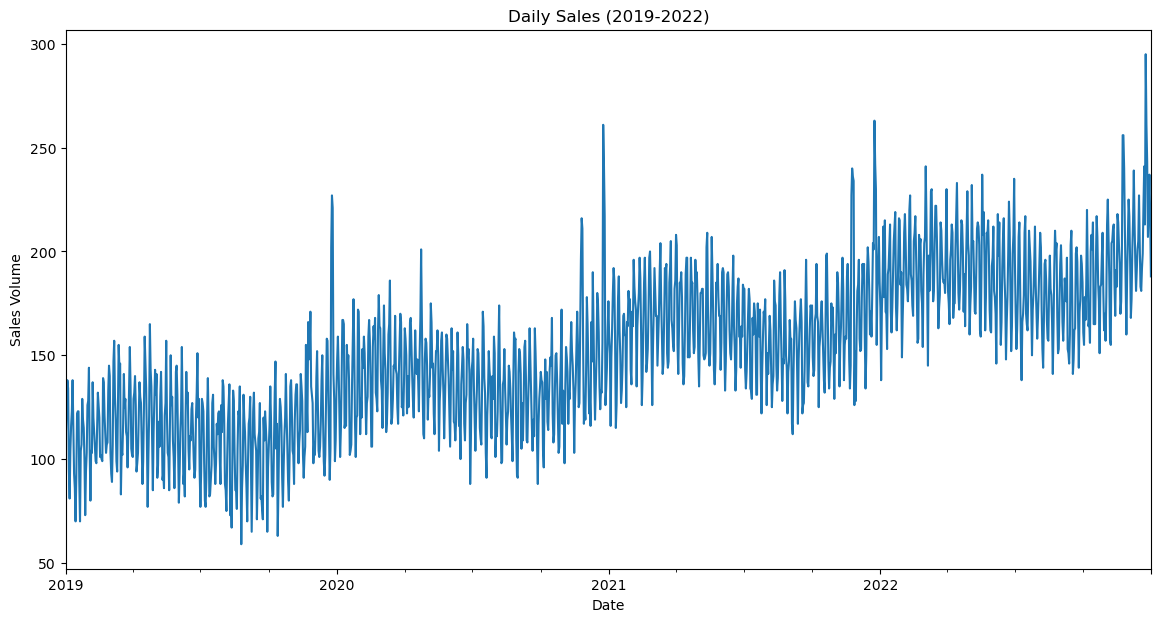

In [3]:
# ======================
# 2. EXPLORATORY ANALYSIS
# ======================
plt.figure(figsize=(14, 7))
sales_df['Sales'].plot(title='Daily Sales (2019-2022)')
plt.ylabel('Sales Volume')
plt.show()

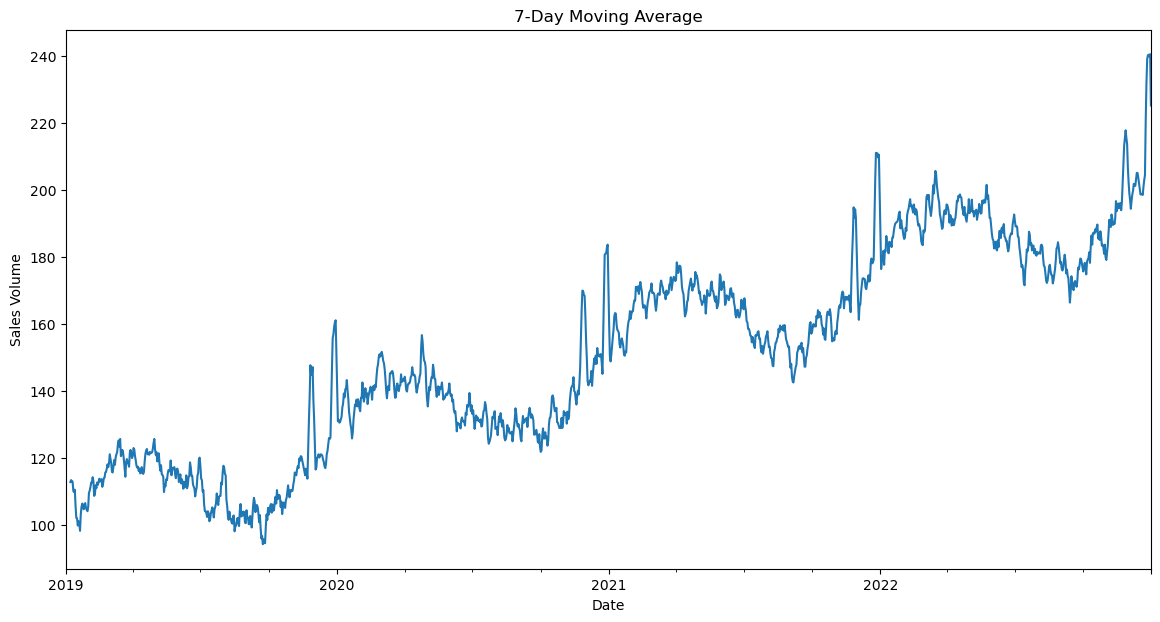

In [4]:
# Weekly moving average
plt.figure(figsize=(14, 7))
sales_df['Sales'].rolling(window=7).mean().plot(title='7-Day Moving Average')
plt.ylabel('Sales Volume')
plt.show()

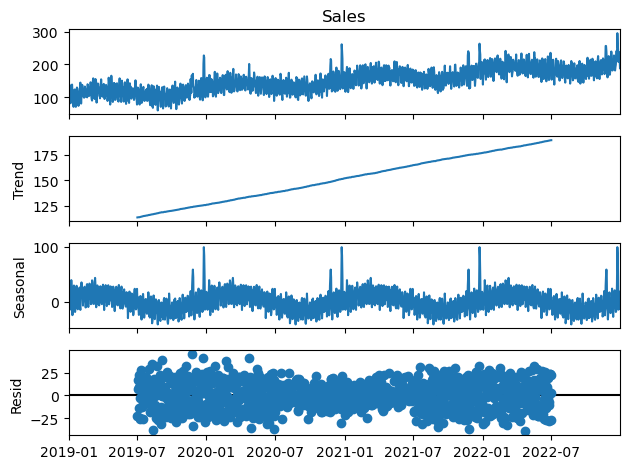

In [5]:
# Seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(sales_df['Sales'], period=365)
decomposition.plot()
plt.tight_layout()
plt.show()

In [6]:
# ======================
# 3. STATIONARITY CHECK
# ======================
def check_stationarity(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    
    if result[1] <= 0.05:
        print("Data is stationary")
    else:
        print("Data is non-stationary")

print("\nStationarity Check:")
check_stationarity(sales_df['Sales'])


Stationarity Check:
ADF Statistic: -0.5720703184298643
p-value: 0.8771689334175954
Critical Values: {'1%': -3.434908816804013, '5%': -2.863553406963303, '10%': -2.5678419239852994}
Data is non-stationary


In [7]:
# ======================
# 4. ARIMA MODELING
# ======================
# Train-test split (80-20)
train_size = int(len(sales_df) * 0.8)
train, test = sales_df.iloc[:train_size], sales_df.iloc[train_size:]

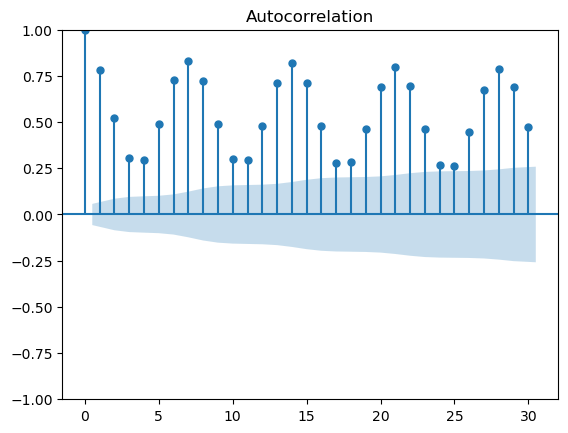

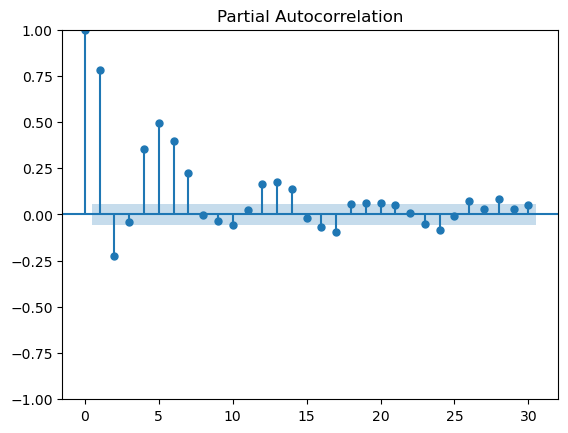

In [8]:
# Determine ARIMA parameters
plot_acf(train['Sales'], lags=30)
plot_pacf(train['Sales'], lags=30)
plt.show()

In [9]:
# Fit ARIMA model (parameters determined from ACF/PACF)
model = ARIMA(train['Sales'], order=(2,1,2), seasonal_order=(1,1,1,7))
model_fit = model.fit()
print(model_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             Sales   No. Observations:                 1168
Model:             ARIMA(2, 1, 2)x(1, 1, [1], 7)   Log Likelihood               -4639.121
Date:                           Sun, 20 Apr 2025   AIC                           9292.243
Time:                                   17:28:42   BIC                           9327.636
Sample:                               01-01-2019   HQIC                          9305.597
                                    - 03-13-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7162      0.042    -16.921      0.000      -0.799      -0.633
ar.L2          0.2589      0.024     10.880

In [10]:
# ======================
# 5. FORECASTING & EVALUATION
# ======================
# Forecast on test set
forecast = model_fit.get_forecast(steps=len(test))
forecast_df = pd.DataFrame({
    'Date': test.index,
    'Actual': test['Sales'],
    'Forecast': forecast.predicted_mean,
    'CI_lower': forecast.conf_int()['lower Sales'],
    'CI_upper': forecast.conf_int()['upper Sales']
})

In [11]:
# Calculate metrics
rmse = np.sqrt(mean_squared_error(forecast_df['Actual'], forecast_df['Forecast']))
mape = mean_absolute_percentage_error(forecast_df['Actual'], forecast_df['Forecast'])
print(f"\nModel Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape*100:.2f}%")


Model Performance:
RMSE: 25.42
MAPE: 11.95%


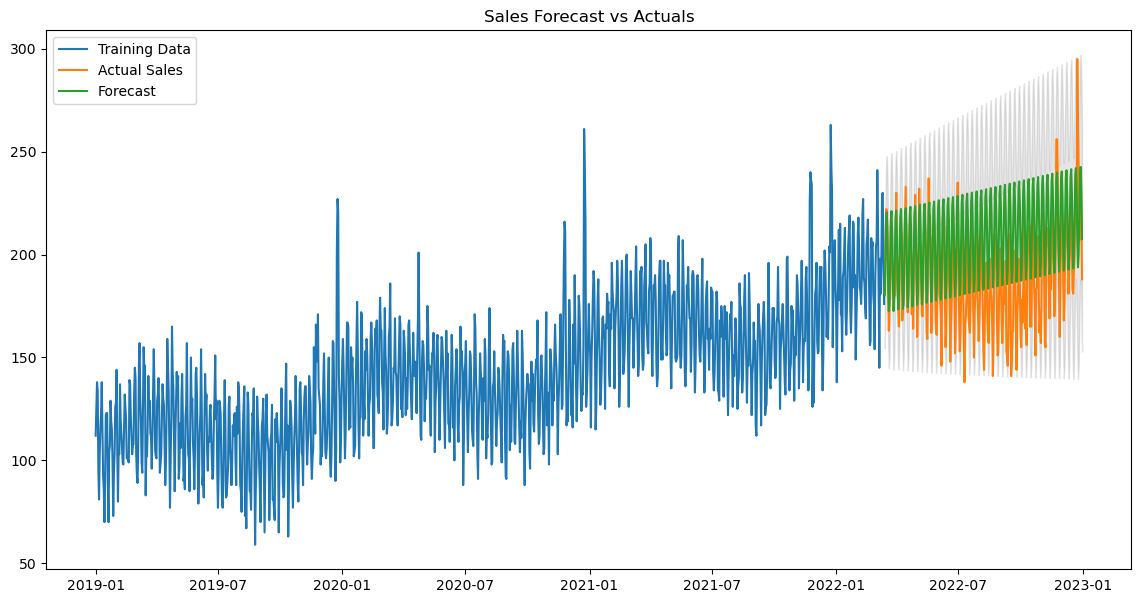

In [12]:
# ======================
# 6. VISUALIZATION
# ======================
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Sales'], label='Training Data')
plt.plot(forecast_df['Date'], forecast_df['Actual'], label='Actual Sales')
plt.plot(forecast_df['Date'], forecast_df['Forecast'], label='Forecast')
plt.fill_between(forecast_df['Date'], 
                forecast_df['CI_lower'], 
                forecast_df['CI_upper'], 
                color='gray', alpha=0.2)
plt.title('Sales Forecast vs Actuals')
plt.legend()
plt.show()

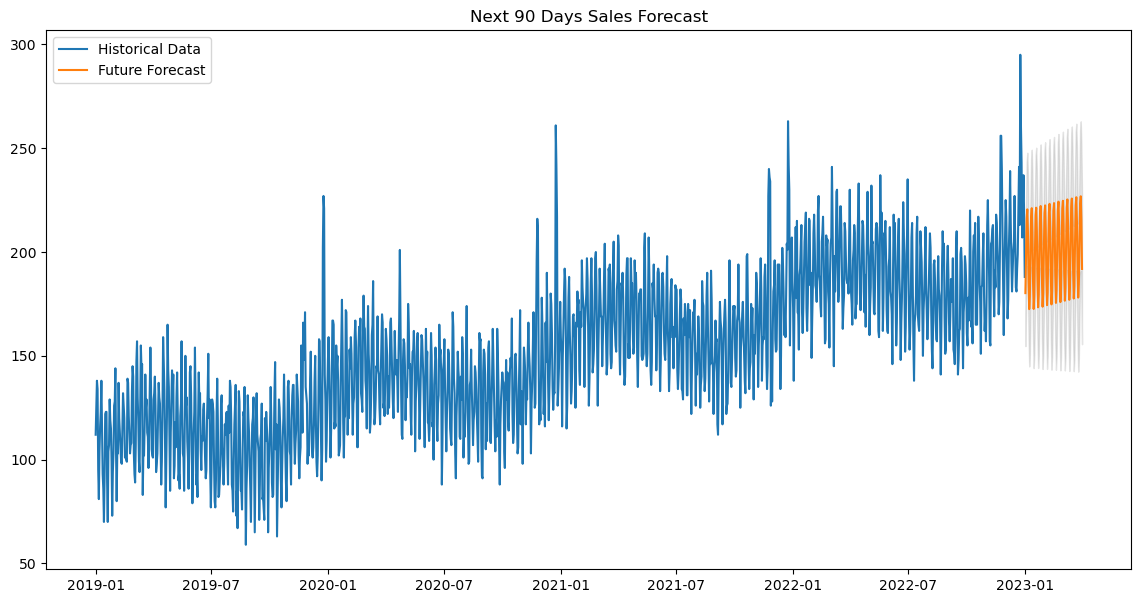

In [13]:
# ======================
# 7. FUTURE FORECASTING
# ======================
future_steps = 90  # Next 3 months
future_forecast = model_fit.get_forecast(steps=future_steps)
future_dates = pd.date_range(start=sales_df.index[-1] + pd.Timedelta(days=1), periods=future_steps)

plt.figure(figsize=(14, 7))
plt.plot(sales_df.index, sales_df['Sales'], label='Historical Data')
plt.plot(future_dates, future_forecast.predicted_mean, label='Future Forecast')
plt.fill_between(future_dates,
                future_forecast.conf_int()['lower Sales'],
                future_forecast.conf_int()['upper Sales'],
                color='gray', alpha=0.2)
plt.title(f'Next {future_steps} Days Sales Forecast')
plt.legend()
plt.show()

In [14]:
# Create forecast table
forecast_table = pd.DataFrame({
    'Date': future_dates,
    'Forecasted_Sales': future_forecast.predicted_mean.round(),
    'Lower_Bound': future_forecast.conf_int()['lower Sales'].round(),
    'Upper_Bound': future_forecast.conf_int()['upper Sales'].round()
})
print("\nFuture Sales Forecast:")
print(forecast_table.head(10))


Future Sales Forecast:
                 Date  Forecasted_Sales  Lower_Bound  Upper_Bound
2022-03-14 2023-01-01             180.0        155.0        206.0
2022-03-15 2023-01-02             198.0        171.0        224.0
2022-03-16 2023-01-03             216.0        189.0        243.0
2022-03-17 2023-01-04             221.0        193.0        248.0
2022-03-18 2023-01-05             210.0        182.0        237.0
2022-03-19 2023-01-06             186.0        158.0        213.0
2022-03-20 2023-01-07             172.0        145.0        200.0
2022-03-21 2023-01-08             178.0        151.0        206.0
2022-03-22 2023-01-09             199.0        171.0        227.0
2022-03-23 2023-01-10             217.0        189.0        245.0
